# input: 
seperate RFP and DAPI flourecent image pairs ( reffered to as red_img and blue_img)


In [56]:
# load images and set up paths


import numpy as np
from skimage.segmentation import expand_labels, watershed, find_boundaries
from scipy.ndimage import label as ndi_label, distance_transform_edt
import tifffile, cv2
from pathlib import Path
from skimage import morphology

notebook = Path(r"/home/phillip/documents/lysozyme/lysozyme-stain-quantification/docs/pipelineTheory.ipynb")

# go up to the project folder "lysozyme stain quantification"
project_root = notebook.parent.parent.parent



# Reuse existing 'pairs' if created earlier; otherwise build it quickly.
if 'pairs' not in globals():
    images_root = project_root / 'lysozyme images'
    red_files = sorted(list(images_root.rglob('*_RFP.tif')) + list(images_root.rglob('*_RFP.tiff')))
    def _match_blue(r_path: Path):
        stem = r_path.name
        if '_RFP.' not in stem:
            return None
        base = stem.split('_RFP.')[0]
        for ext in ['tif','tiff','TIF','TIFF']:
            cand = r_path.with_name(f'{base}_DAPI.{ext}')
            if cand.exists():
                return cand
        return None
    pairs = []
    for _r in red_files:
        b = _match_blue(_r)
        if b is not None:
            pairs.append((_r,b))
        if len(pairs) >= 30:
            break
    if not pairs:
        print('No RFP/DAPI pairs found. Aborting init cell.')

# Helper loaders (reuse if already defined).
if 'load_as_gray' not in globals():
    def load_as_gray(p: Path):
        arr = tifffile.imread(p)
        if arr.ndim == 3:
            if arr.shape[0] <= 4 and arr.shape[0] < arr.shape[-1]:
                arr = np.moveaxis(arr, 0, -1)
            if arr.shape[-1] in (3,4):
                arr = cv2.cvtColor(arr[..., :3].astype(np.uint8), cv2.COLOR_RGB2GRAY)
            else:
                arr = arr[...,0]
        return arr.astype(np.float32)
def build_rgb(red_gray, blue_gray):
    """
    Build RGB image from red and blue grayscale channels.
    
    Args:
        red_gray: Red channel as grayscale array
        blue_gray: Blue channel as grayscale array
    
    Returns:
        RGB image as uint8 numpy array
    """
    import numpy as np
    
    def to_u8(x):
        if x.dtype != np.uint8:
            lo, hi = np.nanmin(x), np.nanmax(x)
            if hi > lo:
                x = (x - lo) / (hi - lo) * 255.0
            else:
                x = np.zeros_like(x)
            return x.astype(np.uint8)
        return x
    
    r8 = to_u8(red_gray)
    b8 = to_u8(blue_gray)
    zeros = np.zeros_like(r8)
    
    return np.stack([r8, zeros, b8], axis=-1)
# Provided helper: minmax01
def minmax01(x, eps=1e-12):
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)

def _calculate_intensity_metrics( ws_labels, red_img, blue_img):
    """
    Calculate background tissue intensity and average crypt intensity
    before removing region 1 (background tissue).
    
    Args:
        ws_labels: Watershed labels array
        red_img: Red channel image
        blue_img: Blue channel image
    """
    # Calculate background tissue intensity (region 1) - optimized
    background_mask = (ws_labels == 1)
    background_tissue_intensity = 0.0
    if np.any(background_mask):
        # Use vectorized operations to avoid creating temporary arrays
        red_bg = red_img[background_mask]
        blue_bg = blue_img[background_mask]
        valid_mask = blue_bg > 1e-10  # Small threshold to avoid division by zero
        if np.any(valid_mask):
            background_tissue_intensity = np.mean(red_bg[valid_mask] / blue_bg[valid_mask])
    
    # Calculate average crypt intensity (all other regions excluding 0) - optimized
    crypt_mask = (ws_labels > 1)
    average_crypt_intensity = 0.0
    if np.any(crypt_mask):
        red_crypt = red_img[crypt_mask]
        blue_crypt = blue_img[crypt_mask]
        valid_mask = blue_crypt > 1e-10  # Small threshold to avoid division by zero
        if np.any(valid_mask):
            average_crypt_intensity = np.mean(red_crypt[valid_mask] / blue_crypt[valid_mask])
    
    # Store in debug info for access by the processor
    return (background_tissue_intensity,
            average_crypt_intensity)




# pipeline:
    (red_image, blue_img) -> 
    grayscale ->  


## extractor_run: ->
    red_img & blue_img -> %%it looks like i dont normalize them%%
    prep grayscale masks: ->
        mask_r_dilation = np.maximum(blue, red) 
        mask_r_erosion = np.minimum(blue, red)
        %%these are np/ basicaly images of where each pixel value comes from whichever wins there%%
    


Text(0.5, 1.0, 'Blue channel (DAPI)')

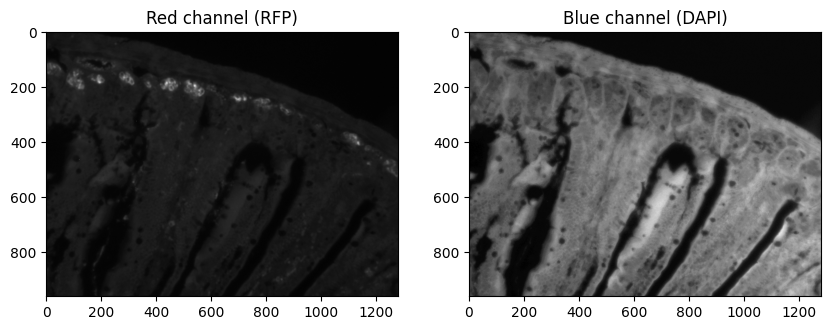

In [46]:
import matplotlib.pyplot as plt
# pick a random pair from the first `max_samples` (change 30 to your desired cap)

max_samples = min(len(pairs), 30)
idx = np.random.randint(0, max_samples)
red_img = (load_as_gray(pairs[idx][0]))
blue_img = (load_as_gray(pairs[idx][1]))
plt, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(red_img, cmap='gray')
ax[0].set_title('Red channel (RFP)')
ax[1].imshow(blue_img, cmap='gray')
ax[1].set_title('Blue channel (DAPI)')

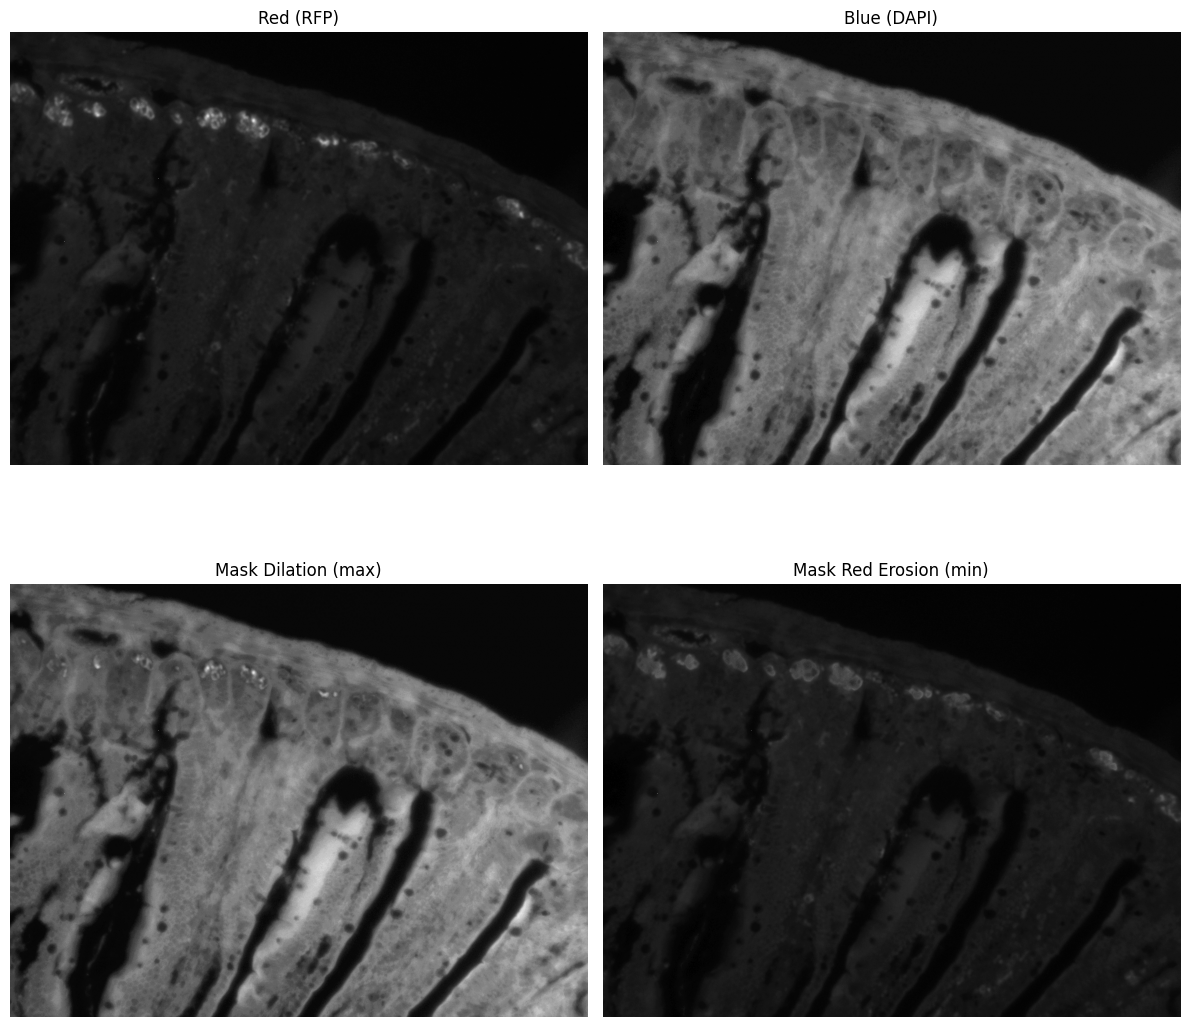

In [47]:
import numpy as np
from skimage.segmentation import watershed
from scipy.ndimage import label as ndi_label, distance_transform_edt
import cv2
from skimage import morphology
import matplotlib.pyplot as plt


# Build RGB display image to match notebook exactly
disp = build_rgb(red_img, blue_img)

# Extract red and blue channels from the RGB display (this is key!)
# This matches the notebook: red = disp[...,0].astype(np.float32)
red = disp[..., 0].astype(np.float32)
blue = disp[..., 2].astype(np.float32)


# Simple morphological reconstruction style differences (matching notebook exactly)
mask_r_dilation = np.maximum(blue, red)
mask_r_erosion = np.minimum(blue, red)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0,0].imshow(red, cmap='gray'); axes[0,0].set_title('Red (RFP)')
axes[0,1].imshow(blue, cmap='gray'); axes[0,1].set_title('Blue (DAPI)')
axes[1,0].imshow(mask_r_dilation, cmap='gray'); axes[1,0].set_title('Mask Dilation (max)')
axes[1,1].imshow(mask_r_erosion, cmap='gray'); axes[1,1].set_title('Mask Red Erosion (min)')
for ax in axes.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()


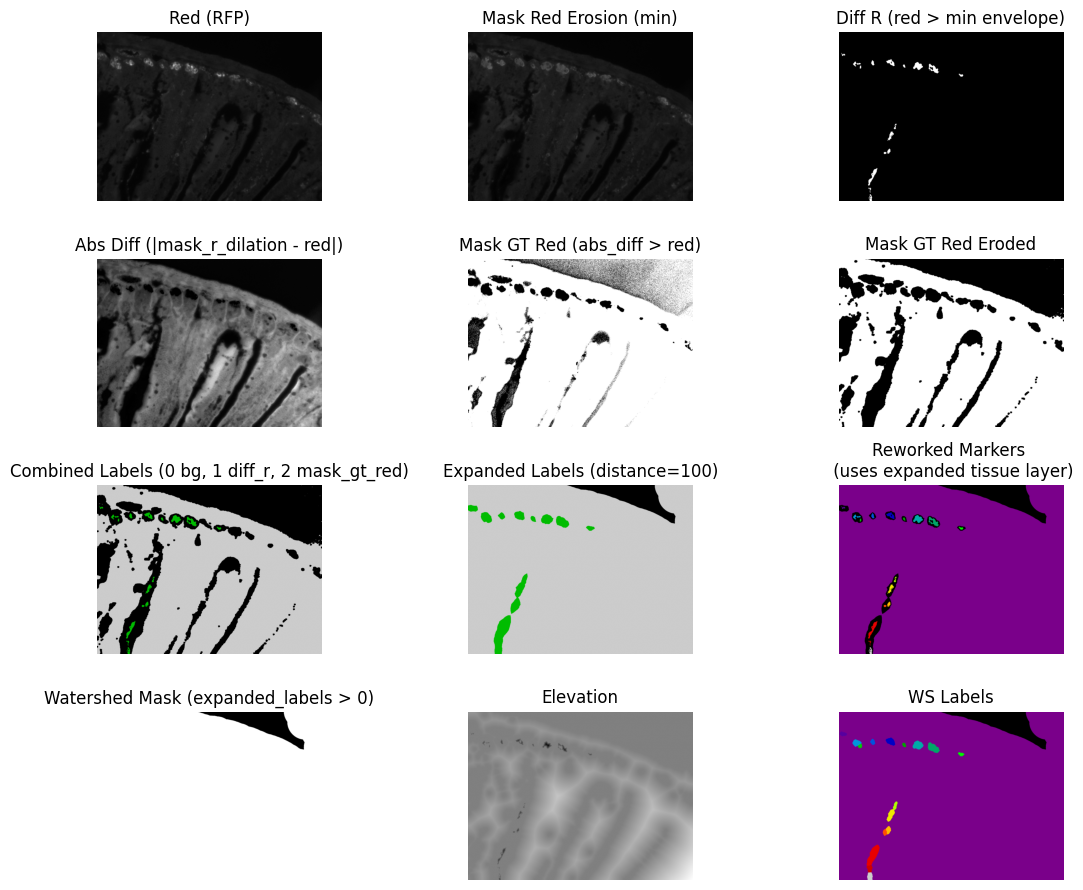

Background Tissue Intensity: 0.5709347724914551
Average Crypt Intensity: 1.7291204929351807


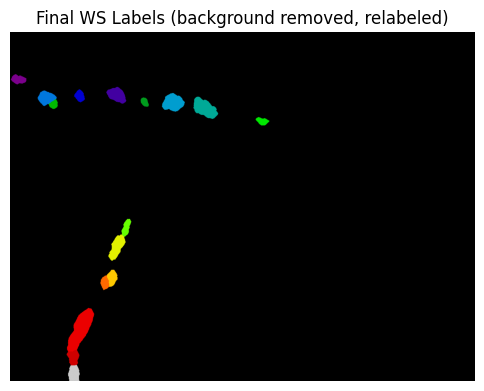

In [58]:

# diff_r: red stronger than min envelope (exact notebook logic)
diff_r = red > mask_r_erosion


diff_r = morphology.binary_erosion(diff_r, footprint=np.ones((3, 3)))
diff_r = morphology.remove_small_objects(diff_r, min_size=100)




fig2, ax2 = plt.subplots(4, 3, figsize=(4*3, 3*3))
ax2[0,0].imshow(red, cmap='gray'); ax2[0,0].set_title('Red (RFP)')
ax2[0,1].imshow(mask_r_erosion, cmap='gray'); ax2[0,1].set_title('Mask Red Erosion (min)')
ax2[0,2].imshow(diff_r, cmap='gray'); ax2[0,2].set_title('Diff R (red > min envelope)')
# Secondary mask using absolute difference (exact notebook logic)
abs_diff = np.abs(mask_r_dilation - red)
mask_gt_red = abs_diff > red


# Erode the secondary mask (exact notebook parameters)
erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
mask_u8 = (mask_gt_red.astype(np.uint8) * 255)
mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=2)
mask_gt_red_eroded = mask_eroded_u8.astype(bool)

## show abs_diff and mask_gt_red and mask_gt_red_eroded
ax2[1,0].imshow(abs_diff, cmap='gray'); ax2[1,0].set_title('Abs Diff (|mask_r_dilation - red|)')
ax2[1,1].imshow(mask_gt_red, cmap='gray'); ax2[1,1].set_title('Mask GT Red (abs_diff > red)')
ax2[1,2].imshow(mask_gt_red_eroded, cmap='gray'); ax2[1,2].set_title('Mask GT Red Eroded')

# Build combined_labels (0 bg, 1 diff_r, 2 mask_gt_red) - exact notebook
combined_labels = np.zeros_like(diff_r, dtype=int)
combined_labels[mask_gt_red_eroded] = 2
combined_labels[diff_r] = 1


# Expand labels (exact notebook distance=100)
expanded_labels = expand_labels(combined_labels, distance=100)


# Markers from diff_r (exact notebook logic)
labeled_diff_r, _ = ndi_label(diff_r != 0)

## show combined_labels, expanded_labels, labeled_diff_r
ax2[2,0].imshow(combined_labels, cmap='nipy_spectral'); ax2[2,0].set_title('Combined Labels (0 bg, 1 diff_r, 2 mask_gt_red)')
ax2[2,1].imshow(expanded_labels, cmap='nipy_spectral'); ax2[2,1].set_title('Expanded Labels (distance=100)')


# Reworked markers array (exact notebook logic)
reworked = np.zeros_like(expanded_labels, dtype=np.int32)
reworked[expanded_labels == 2] = 1  # entire class 2 region => marker 1
mask_copy = (expanded_labels != 2) & (labeled_diff_r != 0)
reworked[mask_copy] = labeled_diff_r[mask_copy] + 1

## show reworked
ax2[2,2].imshow(reworked, cmap='nipy_spectral'); ax2[2,2].set_title('Reworked Markers \n (uses expanded tissue layer)')


# Watershed mask (exact notebook logic)
mask_ws = expanded_labels > 0



# Elevation: attract to class 2, repel from class 1 (exact notebook)
elevation = (
    minmax01(distance_transform_edt(combined_labels == 2))
    - minmax01(distance_transform_edt(combined_labels == 1))
)


# Apply watershed (exact notebook logic)
ws_labels = watershed(elevation, markers=reworked, mask=mask_ws)


# show watershed mask, elevation, and ws_labels
ax2[3,0].imshow(mask_ws, cmap='gray'); ax2[3,0].set_title('Watershed Mask (expanded_labels > 0)')
ax2[3,1].imshow(elevation, cmap='gray'); ax2[3,1].set_title('Elevation')
ax2[3,2].imshow(ws_labels, cmap='nipy_spectral'); ax2[3,2].set_title('WS Labels')
for ax2 in ax2.ravel():
    ax2.axis('off')
plt.tight_layout()
plt.show()

# Calculate background and crypt intensities before removing region 1
ws_labels_pre = ws_labels.copy()
a,b = _calculate_intensity_metrics(ws_labels_pre, red_img, blue_img)
# print results
print(f"Background Tissue Intensity: {a}")
print(f"Average Crypt Intensity: {b}")
# Remove background label (1) and relabel others sequentially starting from 1
ws_labels[ws_labels == 1] = 0
ws_labels[ws_labels > 1] = ws_labels[ws_labels > 1] - 1
# finaly show the final ws_labels
plt.figure(figsize=(6,6))
plt.imshow(ws_labels, cmap='nipy_spectral')
plt.title('Final WS Labels (background removed, relabeled)')
plt.axis('off')
plt.show()

